### Query to get the actual data + save as parquet in S3

In [77]:
bag_data_full = spark.sql("""
select 
   pb.rec_loc,
   pb.flight_sk,
   pb.booking_date as dt_booking,
   pb.flight_date as dt_flight,
   pb.price as price_anc1,
   datediff(pb.flight_date, pb.booking_date) as antel_compra1, 
   f.km,
   f.seats,
   f.idstatus,
   f.route,
   f.route_m,
   r.passengers_nr as passangers,
   r.trip_duration_nr as trip_duration,
   r.trip_weekend_nr as weekend_trip,
   r.isfamilytrip_nr as family_trip,
   r.antel_compra_nr as antel_compra,
   r.couple_travel as couple_trip,
   r.flight_type_tc as RT_OW,
   fs.family_fare,
   fs.ticket_amount as price_ticket,
   ql2.price_comp,
   case when oh.at_dt_flight is not null or dh.at_dt_flight is not null then 1 else 0 end as festivity,
   season.anc_season as season,
   concat(cast(cr.cluster_afp as varchar(2)), '_', cast(cr.cluster as varchar(2))) as cluster_concat,
   cast(cr.cluster_afp as varchar(2)) as cluster_micro,
   cast(cr.cluster as varchar(2)) as cluster_macro,
   anc.sales_qty,
   anc.price_unit,
   anc.date_anc,
   case when pba.price is not null then pba.price else pb.price end as price_anc,
   case when pba.price is not null then 1 else 0 end as price_compra_index,
   case when pba.fee_date is not null then pba.fee_date else cast(pb.booking_date as date) end as anci_compra_date
from 
	ancillary.ds_price_bags_seg pb
left join 
	ancillary.ds_flights f 
	on f.flight_sk = pb.flight_sk
left join 
	ancillary.ds_recloc r
	on r.rec_loc_tx = pb.rec_loc
left join 
	(
	select 
        seg.rec_loc, 
        seg.flight_sk, 
		max(seg.family_fare) as family_fare, 
        avg(seg.tax_2 + seg.tax_3 + seg.tax_4 + seg.tax_5 + seg.tax_6 + seg.cdiscount) as ticket_amount
	from 
		ancillary.ds_segment seg 
	where cast(booking_date as date) between '2018-04-01' and '2019-04-01'
	group by 
    seg.rec_loc,
    seg.flight_sk
	) fs
on fs.rec_loc = pb.rec_loc and fs.flight_sk = f.flight_sk
left join
	(
	select concat(origin, destination) as route, avg(price) as price_comp
	from 
		ancillary.ql2_competitor_hi
	where carrier <> 'VY' --and cast(outbound_departure_date as date) >= '2016-11-10'
	group by concat(origin, destination)
	) ql2
on ql2.route = f.route
left join
	ancillary.dim_holiday_airport oh
	on oh.at_cd_airport = f.airport_orig and oh.at_dt_flight = f.flight_date
left join 
	ancillary.dim_holiday_airport dh
	on dh.at_cd_airport = f.airport_dest and dh.at_dt_flight = f.flight_date
left join 
	ancillary.ds_anc_season season
	on f.flight_date between season.start_dt and season.end_dt
left join 
	ancillary.rs_cluster_routes cr
	on cr.route_m = f.route_m
left join
	(
	select 
		anc.flight_sk, anc.rec_loc, sum(anc.sales_qty) as sales_qty,
		avg(anc.price_unit) as price_unit, max(anc.fee_date) as date_anc
	from ancillary.ds_ancillary anc
	where 1=1
		and anc.DS_REVEN_CONCEPT_3 like '%BAGGAGE%'
		and anc.DS_REVEN_CONCEPT_3 not like '%TTOO%' 
		and anc.DS_REVEN_CONCEPT_3 not like '%AIRPORT%'
		and anc.DS_REVEN_CONCEPT_3 not like '%CALL%' 
		and anc.DS_REVEN_CONCEPT_0 not in ('BAG2','BAG3','BAG4','BAG5','BAG6','SPCXIB','SETO')
		and anc.DS_REVEN_CONCEPT_2 not like '%XTRA BAGGAGE%'
		and anc.total_cost > 0
	group by anc.flight_sk, anc.rec_loc
	) anc
	on anc.rec_loc = pb.rec_loc and anc.flight_sk = f.flight_sk
left join
	(
	select rec_loc,flight_sk, avg(price) as price, max(fee_date) as fee_date
	from 
		ancillary.ds_price_bags_anc 
	group by rec_loc,flight_sk
	) pba
	on pba.rec_loc = pb.rec_loc and pba.flight_sk = pb.flight_sk
where 1=1
	and cast(booking_date as date) between '2018-04-01' and '2019-04-01'
	--and (
	--	   upper(fs.family_fare) like 'BASIC%'
	--	or upper(fs.family_fare) like 'OPTIM%'
	--	or upper(fs.family_fare) like 'EXCELL%'
	--	)
	--and (anc.price_unit <= 29 or anc.price_unit is null)
    """)

#bag_data_full.write.format('parquet').mode('overwrite').save('s3://vueling-data-lake/3-analytics/datasets/ds-classification-bag/new_bag_classif_data.parquet')

In [1]:
import numpy as np
import pandas as pd
import category_encoders as ce
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from functools import reduce
#from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoderModel, OneHotEncoder, StringIndexer, VectorAssembler, RFormula
from pyspark.ml.regression import RandomForestRegressor as RFRegr, RandomForestRegressionModel
from pyspark.sql.types import *
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import lit, when, col, month, dayofweek, sin,cos
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
spark = SparkSession\
        .builder\
        .appName("proceso-mediana")\
        .config("spark.dynamicAllocation.enabled", 'true')\
        .config("spark.dynamicAllocation.maxExecutors", '8')\
        .config("spark.dynamicAllocation.minExecutors", '2')\
        .config("spark.dynamicAllocation.initialExecutors", '2')\
        .config('spark.executor.cores', '8')\
        .config('spark.cores.max', '12')\
        .config("spark.executor.memory", '6g')\
        .config("spark.driver.memory", '15g')\
        .config("spark.driver.maxResultSize", '7g')\
        .config("spark.sql.crossJoin.enabled", "true")\
        .config("spark.shuffle.service.enabled", "true")\
        .config("spark.sql.parquet.writeLegacyFormat", "true")\
        .config("spark.executor.memoryOverhead", "2g")\
        .enableHiveSupport()\
        .getOrCreate()
sqlContext = SQLContext(spark)


In [2]:
#load data
data_new_bags_pnd = spark.read.format('parquet')\
.load('s3://vueling-data-lake/3-analytics/datasets/ds-classification-bag/new_bag_classif_data.parquet').sample(0.1).toPandas()

In [79]:
data_new_bags_pnd.family_fare.unique()

array(['Basic', 'GDS Optima', 'Iberia Basic', 'Time Flex', 'Optima',
       'NoTax', 'Flex', 'GDS Basic', 'Iberia Optima', 'Posicional',
       'Level Economy', 'Time Flex GDS',
       'Level Economy Unbundled Partner', 'Grupos y TTOO',
       'Level Economy CS', 'Puente Aereo Optima', 'Family First',
       'Level Economy Prime', 'Tui Fly', 'ZED LOW', 'GDS Excellence',
       'Level Economy Bundled Partner', 'BAG Flex', 'Excellence',
       'British Airways', 'ZED Medium', 'Level Premium Economy VY',
       'Level Economy Unbundled VY', 'Level Premium Economy',
       'Level Premium Economy Partner', 'Level Premium Economy CS',
       'Level Premium Economy Prime', 'Puente Aereo Excellence',
       'Level Economy Flex Partner', 'Level Incidencias',
       'Iberia Excellence', 'Undefined',
       'Level Premium Economy Flex Partner', 'ZED High', 'Level Groups'],
      dtype=object)

In [80]:
data_new_bags_pnd.query('family_fare.str.contains("Basic") or family_fare.str.contains("Optim") or family_fare.str.contains("Excell")').family_fare.unique()

array(['Basic', 'GDS Optima', 'Iberia Basic', 'Optima', 'GDS Basic',
       'Iberia Optima', 'Puente Aereo Optima', 'GDS Excellence',
       'Excellence', 'Puente Aereo Excellence', 'Iberia Excellence'],
      dtype=object)

In [3]:
cols_numerical = ["seats", "km", "passengers", "antel_compra", "trip_duration", "weekend_trip", "family_trip", "couple_trip", 
                 "festivity", 'price_anc', 'price_comp', 'price_ticket', 'id_competitors']
cols_cyclical_in = ['dt_flight_month']
cols_categorical = ["season", "RT_OW", "cluster_micro", "cluster_macro",  "class", "dt_flight_dow", "family_fare"]
data_new_bags_pnd.rename(columns={'passangers': 'passengers'
                                  }, inplace=True)
data_new_bags_pnd['dt_flight_month'] = pd.DatetimeIndex(data_new_bags_pnd['dt_flight']).month
data_new_bags_pnd.sales_qty.fillna(0, inplace=True)
data_new_bags_pnd.price_unit.fillna(0, inplace=True)
mean_comp_price = data_new_bags_pnd.price_comp.mean()
data_new_bags_pnd.price_comp.fillna(mean_comp_price, inplace=True)
data_new_bags_pnd['id_bag'] = 0
data_new_bags_pnd['id_competitors'] = 0
data_new_bags_pnd.loc[data_new_bags_pnd.sales_qty>0, 'id_bag'] = 1
data_new_bags_pnd.loc[data_new_bags_pnd.price_comp!=mean_comp_price, 'id_competitors'] = 1

data_new_bags_pnd.dt_booking = pd.to_datetime(data_new_bags_pnd.dt_booking)
data_new_bags_pnd.dt_flight = pd.to_datetime(data_new_bags_pnd.dt_flight)
data_new_bags_pnd.anci_compra_date = pd.to_datetime(data_new_bags_pnd.anci_compra_date)
data_new_bags_pnd['price_anc_diff'] = data_new_bags_pnd['price_anc'] - data_new_bags_pnd['price_unit']

### FIlter only Basic family fare

In [4]:
data_new_bags_pnd = data_new_bags_pnd.query("family_fare=='Basic'")

### Data summary:

In [86]:
print(data_new_bags_pnd.shape)
print(data_new_bags_pnd.dtypes)
#print(data_new_bags_pnd.info())

(1366849, 36)
rec_loc                       object
flight_sk                    float32
dt_booking            datetime64[ns]
dt_flight             datetime64[ns]
price_anc1                   float32
antel_compra1                  int32
km                           float32
seats                          int32
idstatus                       int32
route                         object
route_m                       object
passengers                     int32
trip_duration                  int32
weekend_trip                   int32
family_trip                    int32
antel_compra                   int32
couple_trip                    int32
RT_OW                         object
family_fare                   object
price_ticket                 float64
price_comp                   float64
festivity                      int32
season                        object
cluster_concat                object
cluster_micro                 object
cluster_macro                 object
sales_qty               

In [87]:
print(data_new_bags_pnd.describe().iloc[:,:20])
print(data_new_bags_pnd.describe().iloc[:,19:])

          flight_sk    price_anc1  antel_compra1            km         seats  \
count  1.366849e+06  1.366849e+06   1.366849e+06  1.366849e+06  1.366849e+06   
mean   6.554603e+06  1.774156e+01   3.885529e+01  9.279493e+02  1.869818e+02   
std    1.447433e+05  3.158869e+00   4.759841e+01  5.147767e+02  1.646524e+01   
min    6.318757e+06  1.000000e+01  -3.000000e+00  1.740000e+02  1.440000e+02   
25%    6.422689e+06  1.500000e+01   7.000000e+00  5.800000e+02  1.800000e+02   
50%    6.592129e+06  1.700000e+01   2.100000e+01  8.350000e+02  1.800000e+02   
75%    6.651256e+06  2.000000e+01   5.200000e+01  1.183000e+03  1.860000e+02   
max    7.103524e+06  3.000000e+01   3.920000e+02  3.592000e+03  2.200000e+02   

           idstatus    passengers  trip_duration  weekend_trip   family_trip  \
count  1.366849e+06  1.366849e+06   1.366849e+06  1.366849e+06  1.366849e+06   
mean   1.000272e+00  1.620093e+00   2.652078e+00  5.322973e-02  5.893848e-02   
std    2.857277e-02  1.063908e+00   5.1

In [88]:
data_new_bags_pnd.loc[:, cols_categorical].describe(include='all')

,season,RT_OW,cluster_micro,cluster_macro,class,dt_flight_dow,family_fare
count,1346860,1366849,1322870,1323650,0.0,0.0,1366849
unique,2,4,24,5,NaN,NaN,1
top,LOW,RT,4,1,NaN,NaN,Basic
freq,898146,756327,242887,652841,NaN,NaN,1366849
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
print(data_new_bags_pnd.id_bag.value_counts(normalize=True))
print(data_new_bags_pnd.id_competitors.value_counts(normalize=True))
print('Part of bookings belonging to Basic fare class: '+str(data_new_bags_pnd.query("family_fare=='Basic'").count()[0]/data_new_bags_pnd.count()[0]))

print('Distribution of bags/no bags for family fare basic: '+str(data_new_bags_pnd.query("family_fare=='Basic'").id_competitors.value_counts(normalize=True)))
print('Distribution of bags/no bags outside family fare basic: '+str(data_new_bags_pnd.query("family_fare!='Basic'").id_competitors.value_counts(normalize=True)))

0    0.860732
1    0.139268
Name: id_bag, dtype: float64
1    0.921595
0    0.078405
Name: id_competitors, dtype: float64
Part of bookings belonging to Basic fare class: 1.0
Distribution of bags/no bags for family fare basic: 1    0.921595
0    0.078405
Name: id_competitors, dtype: float64
Distribution of bags/no bags outside family fare basic: Series([], Name: id_competitors, dtype: float64)


### Correlations:

In [90]:
for i in cols_numerical + cols_cyclical_in:
    print('Correlation with target variable id_bag: ')
    print(i+ ': ' +str(data_new_bags_pnd['id_bag'].corr(data_new_bags_pnd[i])))

Correlation with target variable id_bag: 
seats: -0.005370496162525526
Correlation with target variable id_bag: 
km: 0.10777656873582028
Correlation with target variable id_bag: 
passengers: 0.15369272317577792
Correlation with target variable id_bag: 
antel_compra: 0.06126513386410038
Correlation with target variable id_bag: 
trip_duration: 0.08445252666121571
Correlation with target variable id_bag: 
weekend_trip: -0.07788880325436037
Correlation with target variable id_bag: 
family_trip: 0.12371680075655289
Correlation with target variable id_bag: 
couple_trip: 0.07566092784581731
Correlation with target variable id_bag: 
festivity: nan
Correlation with target variable id_bag: 
price_anc: 0.05788825586529728
Correlation with target variable id_bag: 
price_comp: 0.09231713817592788
Correlation with target variable id_bag: 
price_ticket: 0.07978686624605137
Correlation with target variable id_bag: 
id_competitors: -0.0022472520244555495
Correlation with target variable id_bag: 
dt_fli

### Analyze ancillaries' prices distribution:

price_anc
10.000000     39864
11.000000       131
12.000000      6138
12.500000         1
13.000000     28709
14.000000     53420
15.000000    234726
15.500000         2
16.000000    125888
16.500000        10
17.000000    213372
17.500000        11
18.000000    154693
18.333333         1
18.500000        35
19.000000    100936
19.500000         1
20.000000    175672
20.500000         8
21.000000     64975
21.500000         4
22.000000     77542
23.000000     40854
23.500000         1
24.000000     19738
25.000000     14460
25.500000         2
26.000000      2244
27.000000      6130
28.000000      2775
29.000000      3051
30.000000      1455
Name: rec_loc, dtype: int64
    price_anc           km
0        10.0   425.607635
1        12.0   795.447388
2        13.0   837.741760
3        14.0   983.913208
4        15.0   806.472595
5        16.0   947.497803
6        17.0   860.255188
7        18.0   868.552551
8        19.0   994.357727
9        20.0   901.646301
10       21.0   940.85199

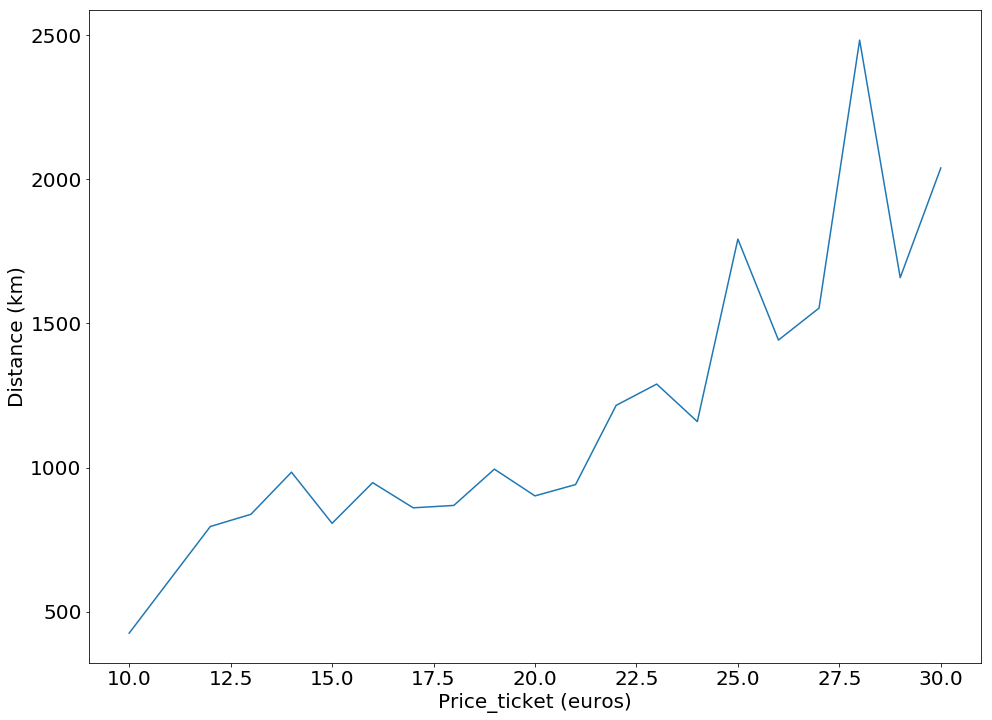

In [91]:
print(data_new_bags_pnd.groupby('price_anc')['rec_loc'].count())
only_sensible_prices = list(data_new_bags_pnd.groupby('price_anc')['rec_loc'].count().reset_index().query("rec_loc > 1000").price_anc)
plot_data_1 = data_new_bags_pnd.query("price_anc == @only_sensible_prices").groupby('price_anc')['km'].mean().reset_index()
print(plot_data_1)
plt.figure(figsize=(16, 12))
plt.plot(plot_data_1.price_anc, plot_data_1.km)
plt.xlabel('Price_ticket (euros)', fontsize=20)
plt.ylabel('Distance (km)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)



#### Only Low Season

price_anc
10.0     39864
11.0       131
12.0      6138
12.5         1
13.0     26319
14.0     50189
15.0    197348
15.5         2
16.0    110351
16.5         8
17.0    109761
17.5         2
18.0     97013
18.5         4
19.0     72725
20.0     94449
20.5         1
21.0     24062
21.5         1
22.0     50276
23.0      6418
24.0      2258
25.0      2794
26.0      1248
27.0      4450
28.0      2333
Name: rec_loc, dtype: int64
    price_anc           km
0        10.0   425.607635
1        12.0   795.447388
2        13.0   864.064880
3        14.0   992.049622
4        15.0   806.001709
5        16.0   935.659912
6        17.0   855.453918
7        18.0   837.618835
8        19.0   971.890198
9        20.0  1137.987427
10       21.0  1245.250732
11       22.0  1282.814209
12       23.0  1468.046631
13       24.0  1536.793213
14       25.0  2072.291016
15       26.0  1569.644287
16       27.0  1515.352173
17       28.0  2401.772705


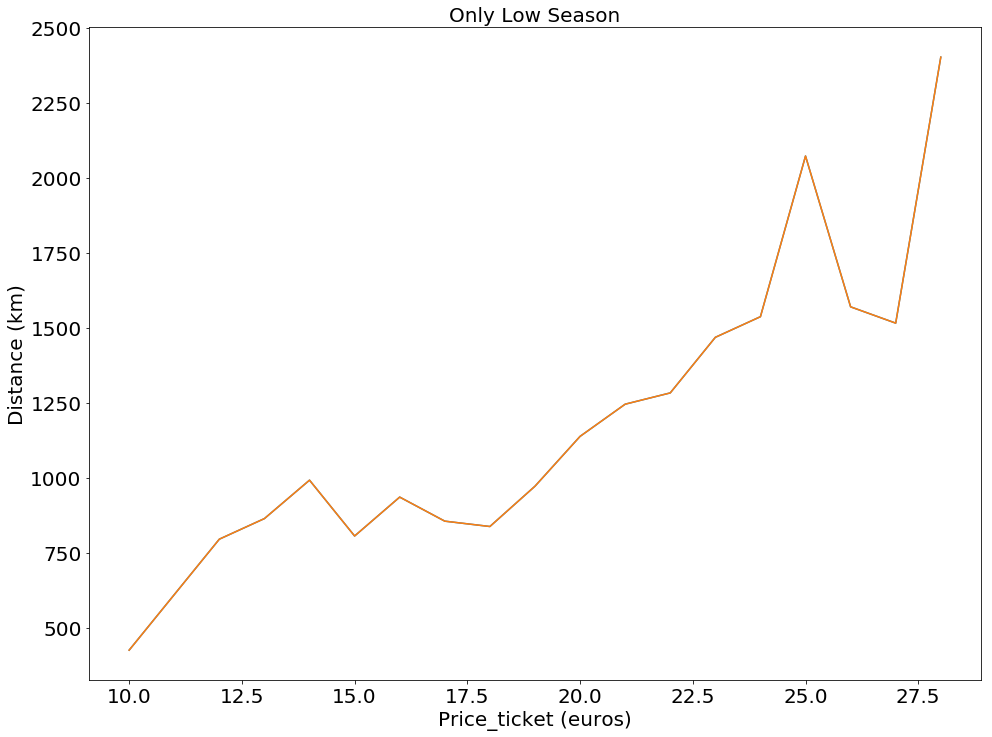

In [93]:
data_tmp1 = data_new_bags_pnd.query('family_fare=="Basic" and season=="LOW"')
print(data_tmp1.groupby('price_anc')['rec_loc'].count())
only_sensible_prices = list(data_tmp1.groupby('price_anc')['rec_loc'].count().reset_index().query("rec_loc > 1000").price_anc)
plot_data_1 = data_tmp1.query("price_anc == @only_sensible_prices").groupby('price_anc')['km'].mean().reset_index()
print(plot_data_1)
plt.figure(figsize=(16, 12))
plt.plot(plot_data_1.price_anc, plot_data_1.km)
plt.plot(plot_data_1.price_anc, plot_data_1.km)
plt.xlabel('Price_ticket (euros)', fontsize=20)
plt.ylabel('Distance (km)', fontsize=20)
plt.title('Only Low Season', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

### Only BCNMAD flights, for different seasons

In [94]:
data_tmp1 = data_new_bags_pnd.query('family_fare=="Basic" and route=="BCNMAD"')
print(data_tmp1.groupby('price_anc')['rec_loc'].count())
only_sensible_prices = list(data_tmp1.groupby('price_anc')['rec_loc'].count().reset_index().query("rec_loc > 1000").price_anc)
plot_data_1 = data_tmp1.query("price_anc == @only_sensible_prices").groupby('price_anc')['km'].mean().reset_index()
print(plot_data_1)

price_anc
10.0    16475
15.0     3908
17.0      326
Name: rec_loc, dtype: int64
   price_anc     km
0       10.0  483.0
1       15.0  483.0


In [84]:
#there is some season=None for family_fares outside Basic
data_new_bags_pnd.query('family_fare=="Basic" and route=="BCNMAD" and season!=season').dt_flight.unique()

array([], dtype='datetime64[ns]')

In [95]:
data_tmp1 = data_new_bags_pnd.query('family_fare=="Basic" and route=="BCNMAD" and season=="HIGH"')
print(data_tmp1.groupby('price_anc')['rec_loc'].count())
data_tmp1 = data_new_bags_pnd.query('family_fare=="Basic" and route=="BCNMAD" and season=="LOW"')
print(data_tmp1.groupby('price_anc')['rec_loc'].count())
data_tmp1 = data_new_bags_pnd.query('family_fare=="Basic" and route=="BCNMAD" and season!=season')
print(data_tmp1.groupby('price_anc')['rec_loc'].count())

price_anc
15.0    3908
Name: rec_loc, dtype: int64
price_anc
10.0    16475
Name: rec_loc, dtype: int64
price_anc
17.0    326
Name: rec_loc, dtype: int64


### Histograms:

Text(0.5, 1.0, 'Bought in Advance')

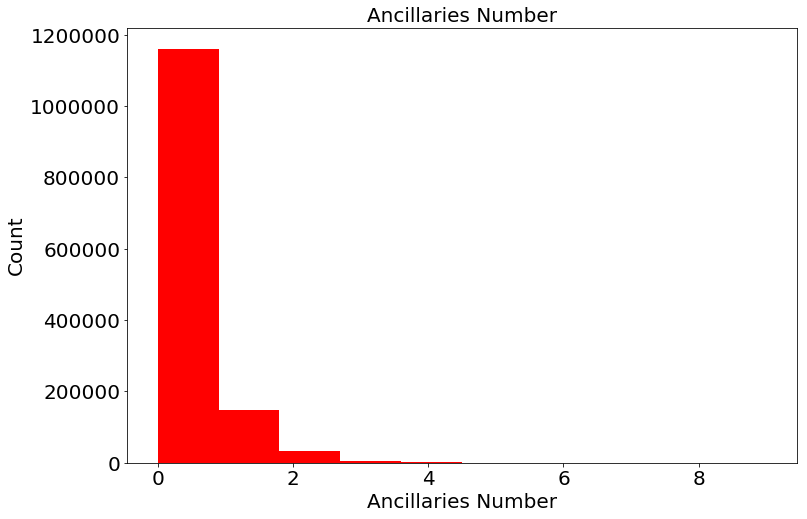

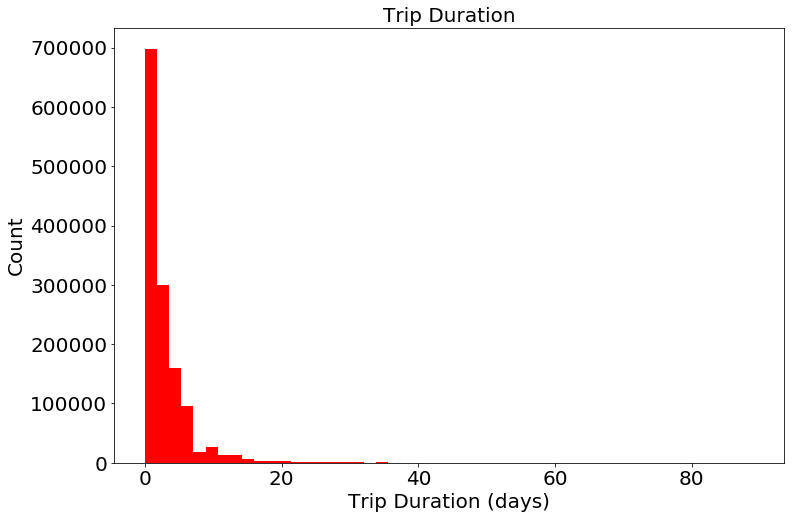

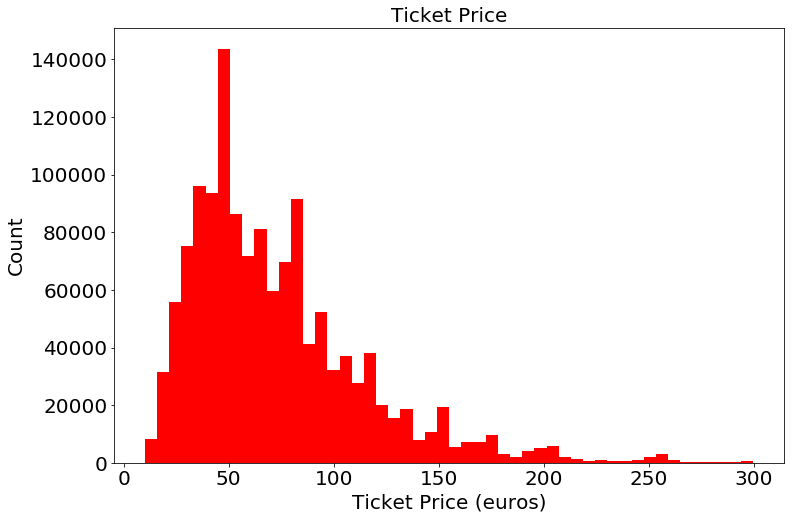

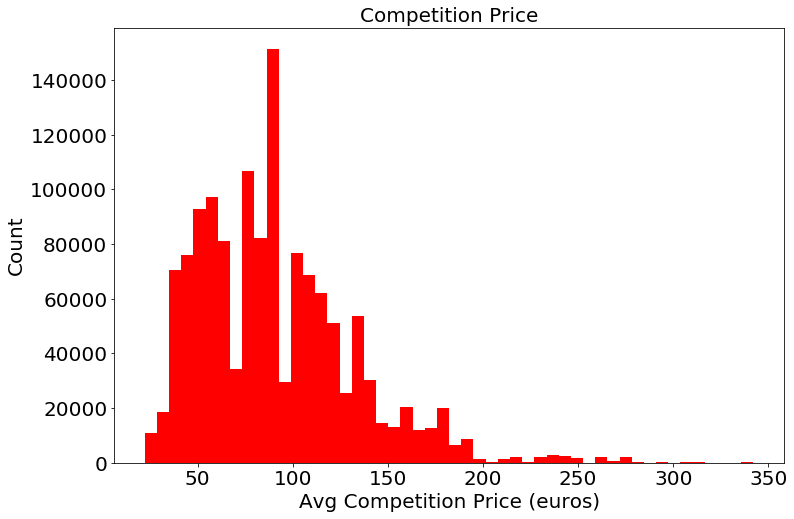

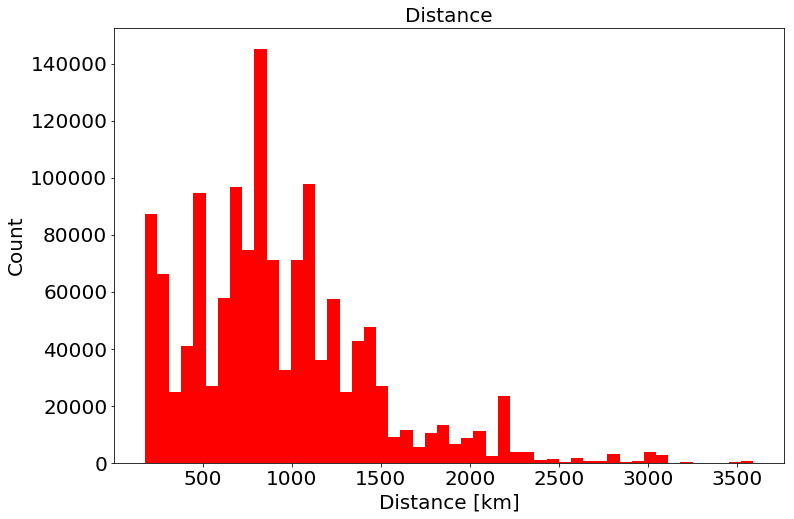

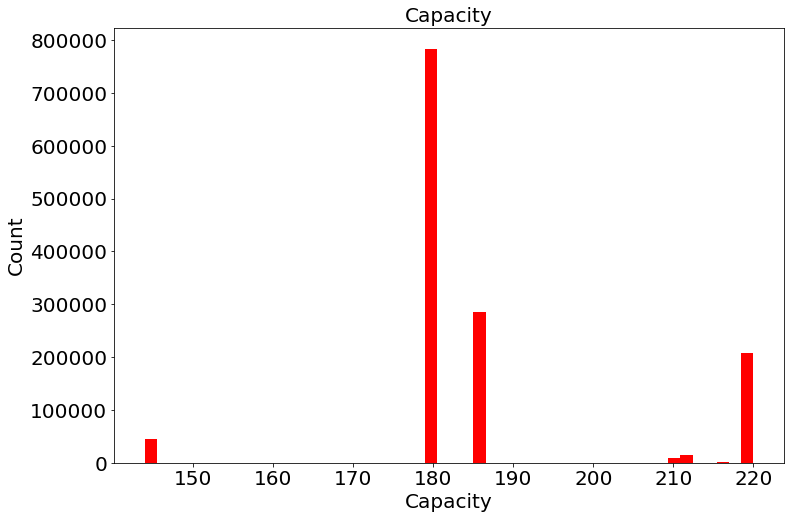

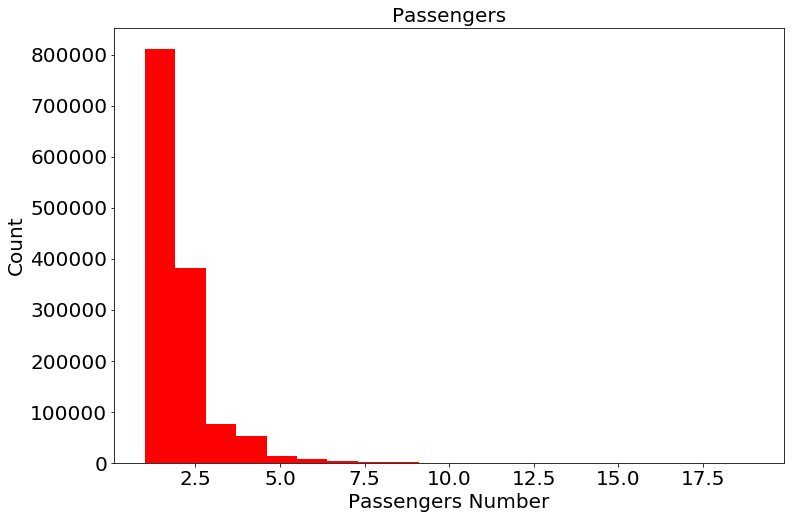

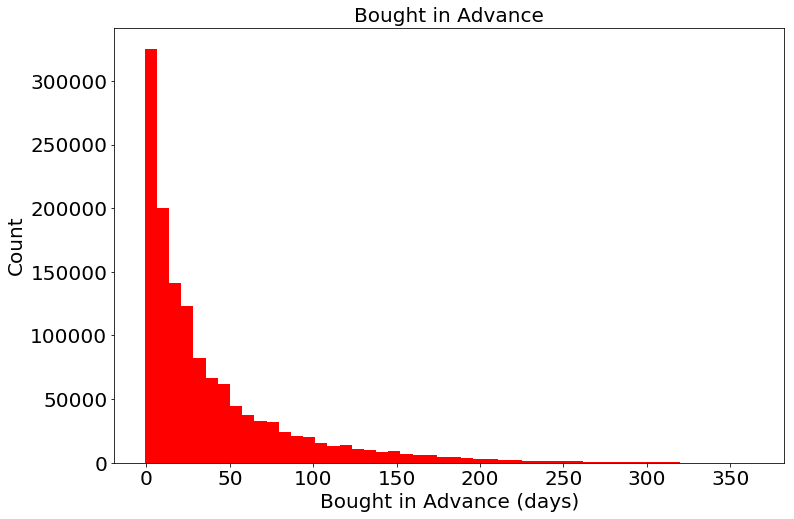

In [99]:
#plt.figure(figsize=(12, 8))
#plt.hist(data_new_bags_pnd.price_anc_diff, color='r', bins=50)
#plt.xlabel('price_anc_diff [km]', fontsize=20)
#plt.ylabel('Count', fontsize=20)
#plt.tick_params(axis='both', which='major', labelsize=20)
#plt.title('price_anc_diff', fontsize=20)

plt.figure(figsize=(12, 8))
plt.hist(data_new_bags_pnd.sales_qty, color='r', bins=10)
plt.xlabel('Ancillaries Number', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Ancillaries Number', fontsize=20)

plt.figure(figsize=(12, 8))
plt.hist(data_new_bags_pnd.trip_duration, color='r', bins=50)
plt.xlabel('Trip Duration (days)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Trip Duration', fontsize=20)

plt.figure(figsize=(12, 8))
plt.hist(data_new_bags_pnd.price_ticket, color='r', bins=50)
plt.xlabel('Ticket Price (euros)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Ticket Price', fontsize=20)

plt.figure(figsize=(12, 8))
plt.hist(data_new_bags_pnd.price_comp, color='r', bins=50)
plt.xlabel('Avg Competition Price (euros)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Competition Price', fontsize=20)

plt.figure(figsize=(12, 8))
plt.hist(data_new_bags_pnd.km, color='r', bins=50)
plt.xlabel('Distance [km]', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Distance', fontsize=20)

plt.figure(figsize=(12, 8))
plt.hist(data_new_bags_pnd.seats, color='r', bins=50)
plt.xlabel('Capacity', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Capacity', fontsize=20)

plt.figure(figsize=(12, 8))
plt.hist(data_new_bags_pnd.passengers, color='r', bins=20)
plt.xlabel('Passengers Number', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Passengers', fontsize=20)

plt.figure(figsize=(12, 8))
plt.hist(data_new_bags_pnd.antel_compra, color='r', bins=50)
plt.xlabel('Bought in Advance (days)', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Bought in Advance', fontsize=20)


In [97]:
#remove outliers
data_new_bags_pnd = data_new_bags_pnd[data_new_bags_pnd.passengers < 20] #92 with value > 20, max 56
data_new_bags_pnd = data_new_bags_pnd[data_new_bags_pnd.antel_compra < 365]# 1 with value -1, 43 with value>365
#data_new_bags_pnd = data_new_bags_pnd[data_new_bags_pnd.price_comp < 300] #618 with value>300, 22-342 euros
data_new_bags_pnd = data_new_bags_pnd[data_new_bags_pnd.price_ticket < 300] #from -10000 to 260000, obviously wrong (nr opf pax included during check)
data_new_bags_pnd = data_new_bags_pnd[data_new_bags_pnd.price_ticket > 10]
data_new_bags_pnd = data_new_bags_pnd[data_new_bags_pnd.trip_duration < 90] #500 with values over 90, 0 for OW
data_new_bags_pnd = data_new_bags_pnd[data_new_bags_pnd.sales_qty < 10] #max is 45, only 53 over 10, equal to pax number
data_new_bags_pnd = data_new_bags_pnd[data_new_bags_pnd.km < 4000] #2 over 4000, max 6800